In [1]:
import numpy as np
import time
import json
from copy import deepcopy as dc
import torch

import joblib
import re

%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from data.utils import votes_filter, plot_overlap_conflict
from data.scicite.utils import load_jsonl, extract_item, get_inst, textsplit

In [2]:
scicite_loc = 'data/scicite/{:s}.jsonl'

train = load_jsonl(dc(scicite_loc).format('train'))
dev = load_jsonl(dc(scicite_loc).format('dev'))
test = load_jsonl(dc(scicite_loc).format('test'))

In [4]:
from nplm.plf import WeakRule, BinaryRERules, regex_decision

train_instances, _ = get_inst(train, keep_instance=True)
dev_instances, dev_labels = get_inst(dev, keep_instance=True)

In [5]:

def df1(instance):
    p, m, s = textsplit(instance, p=False)
    new_sen = re.sub(r'\([^)]*\)', '', p+m+s).lower()
    if ' we ' in new_sen or ' our ' in new_sen or ' by us ' in new_sen:
        return 1
    return -1


firstperson_rule = WeakRule(exec_module=df1, label_maps={0:[0], 1:[1,2]})

v1 = firstperson_rule.execute(dev_instances)
acc, p, r, cwacc = firstperson_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)

re_patt_results = 'result|discussion|conclusion|observation'
re_patt_method = 'method|approach|experiment|evaluation'
re_patt_intro = 'introduction|background'

def sectionTitleRule(instance):
    t = str(instance['sectionName']).lower()
    if regex_decision(re_patt_method, t):
        return 1
    elif regex_decision(re_patt_intro, t):
        return 0
    elif regex_decision(re_patt_results, t):
        return 2
    return -1

sectionTitle_rule = WeakRule(exec_module=sectionTitleRule, label_maps={0:[0], 1:[1], 2:[0, 2]})
v2 = sectionTitle_rule.execute(dev_instances)
acc, p, r, cwacc = sectionTitle_rule.eval(dev_labels, class_wise_acc=True)

print(acc, p, r)
print(cwacc)

def df2(instance):
    p, m, s = textsplit(instance, p=False)
    new_sen = re.sub(r'\([^)]*\)', '', p+s).lower()
    if ' result ' in new_sen or ' results ' in new_sen:
        return 1
    return 0

result_rule = WeakRule(exec_module=df2, label_maps={0:[0,1], 1:[2]})
v3 = result_rule.execute(dev_instances)
acc, p, r, cwacc = result_rule.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)

def length_citation(instance):
    p, m, s = textsplit(instance, p=False)
    if len(m.split(';')) > 2:
        return 1
    return -1

simple_re_rule_0 = WeakRule(exec_module=length_citation, label_maps={0:[2], 1:[0,1]})
v4 = simple_re_rule_0.execute(dev_instances)
acc, p, r, cwacc = simple_re_rule_0.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)



def df3(instance):
    def result_related(inst):
        patterns = ['equivocal result', 'similar result', 'same result', 'different result', 'expected result']
        for pattern in patterns:
            if pattern in inst:
                return 1
        return -1
    p, m, s = textsplit(instance, p=False)
    new_sen = re.sub(r'\([^)]*\)', '', p+s).lower()
    return result_related(new_sen)


res_rule = WeakRule(exec_module=df3, label_maps={0:[1], 1:[0,2]})
v7 = res_rule.execute(dev_instances)
acc, p, r, cwacc = res_rule.eval(dev_labels, class_wise_acc=True, average='macro')
print(acc, p, r)
print(cwacc)

re_patt = 'using|measuring|used|the method|data|state-of-art|calculated|applied|according to|approach'

simple_re_rule_1 = BinaryRERules(re_pattern=re_patt, preproc=lambda inst:inst['string'], label_maps={0:[0,2], 1:[1]}, unipolar=False)
v5 = simple_re_rule_1.execute(dev_instances)

acc, p, r, cwacc = simple_re_rule_1.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)



def df5(instance):    
    def match(inst):
        patterns = [
            'has been', 'in order to', 'considered to', 
            'initially', 'even if','have shown', 'has shown'
        ]
        for pattern in patterns:
            if pattern in inst:
                return 1
        return -1

    p, m, s = textsplit(instance, p=False)
    new_sen = re.sub(r'\([^)]*\)', '', p+s).lower()
    return match(new_sen)


add_rule = WeakRule(exec_module=df5, label_maps={0:[2], 1:[0,1]})
v9 = add_rule.execute(dev_instances)
acc, p, r, cwacc = add_rule.eval(dev_labels, class_wise_acc=True, average='macro')
print(acc, p, r)
print(cwacc)



def df4(instance):
    
    def comparison(inst):
        patterns = [
            'in line with', 'discordant with', 'consistent with', 'keeping with', 'accordance with', 'agreement with', 'similar with',
            'compared to', 'contrast to', 'contrary to', 'comparable to', 'contradict to', 'affirmed by', 'supported by', 'in support of', 
        ]
        for pattern in patterns:
            if pattern in inst:
                return 1
        return -1
    p, m, s = textsplit(instance, p=False)
    new_sen = re.sub(r'\([^)]*\)', '', p+s).lower()
    return comparison(new_sen)


resultp_rule = WeakRule(exec_module=df4, label_maps={0:[0,1], 1:[2]})
v8 = resultp_rule.execute(dev_instances)
acc, p, r, cwacc = resultp_rule.eval(dev_labels, class_wise_acc=True, average='macro')
print(acc, p, r)
print(cwacc)



re_patt = 'our result|this is in keeping|with previous|this study differ|this is in agreement with|this conclusion|this finding|similar result.*(found|observed|obtained)'

re_tb = BinaryRERules(re_pattern=re_patt, preproc=lambda inst:inst['string'], label_maps={0:[0,1], 1:[2]}, unipolar=True)
v5 = re_tb.execute(dev_instances)

acc, p, r, cwacc = re_tb.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)


re_patt = 'we (employ|utilize)|iap-as|metaanalyses|temporal transition|was estimated|quantitative (analyses|analysis)|this procedure|implementation|sequence analysis|regularization method|were analysed|we adopt|bayesian|were sampled|quantitative method|fracture|simulating|this design|algorithm|developed|model performance|(was|were) evaluated|as control|scheme|control management|(was|were|is|are) measured|the rats|the pigs|we appl'

re_tm = BinaryRERules(re_pattern=re_patt, preproc=lambda inst:inst['string'], label_maps={0:[0,2], 1:[1]}, unipolar=True)
v5 = re_tm.execute(dev_instances)

acc, p, r, cwacc = re_tm.eval(dev_labels, class_wise_acc=True)
print(acc, p, r)
print(cwacc)

0.7843137254901961 0.7843137254901961 0.08733624454148471
[0.0, 1.0, 1.0]
0.8837535014005602 0.8760244445497181 0.6888646288209607
[0.9088607594936708, 0.7942583732057417, 0.9636363636363636]
0.8973799126637555 0.7853329989610576 0.8973799126637555
[0.9405204460966543, 0.9803921568627451, 0.5365853658536586]
0.8918918918918919 0.8918918918918919 0.036026200873362446
[1.0, 1.0, 0.0]
1.0 1.0 0.001091703056768559
[1.0, nan, nan]
0.8002183406113537 0.757343631299063 0.8002183406113537
[0.895910780669145, 0.5294117647058824, 0.943089430894309]
0.8378378378378378 0.8378378378378378 0.06768558951965066
[1.0, 1.0, 0.0]
0.7297297297297297 0.7297297297297297 0.05895196506550218
[0.0, 0.0, 1.0]
0.7857142857142857 0.7857142857142857 0.012008733624454149
[0.0, 0.0, 1.0]
0.7142857142857143 0.7142857142857143 0.027292576419213975
[0.0, 1.0, 0.0]


{0: [0], 1: [1, 2]}
{0: [0], 1: [1], 2: [0, 2]}
{0: [0, 1], 1: [2]}
{0: [2], 1: [0, 1]}
{0: [1], 1: [0, 2]}
{0: [0, 2], 1: [1]}
{0: [2], 1: [0, 1]}
{0: [0, 1], 1: [2]}
{0: [0, 1], 1: [2]}
{0: [0, 2], 1: [1]}


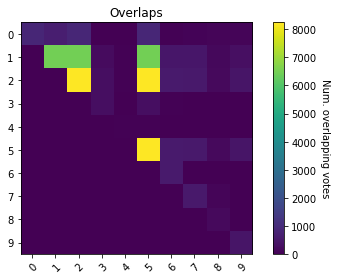

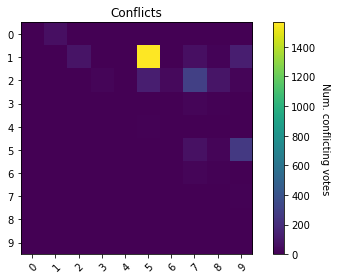

In [6]:
from nplm.plf import executor, evaluator

train_instances, _ = get_inst(train, keep_instance=True)

plfs = [firstperson_rule, sectionTitle_rule, result_rule, 
              simple_re_rule_0,  res_rule, simple_re_rule_1, 
              add_rule, resultp_rule ,re_tb, 
              re_tm]
votes, fid2clusters = executor(plfs, train_instances, one_indexed=False)

votes, _, train_idx = votes_filter(votes, return_idx=True)
plot_overlap_conflict(votes, fid2clusters)

In [7]:
from nplm import PartialLabelModel

lm_cfg={'lr': 0.01,
 'epoch': 5,
 'seed': 0,
 'batch_size': 8192,
 'momentum': 0.9,
 'step_schedule': 'p',
 'step_multiplier': 0.1}

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
labelmodel = PartialLabelModel(num_classes=3,
                        fid2clusters=fid2clusters,
                        opt_cfg=lm_cfg,
                        device=device, verbose=True)

labelmodel.optimize(votes)
label_estim = labelmodel.weak_label(votes)

epoch   1:   0%|          | 0/2 [00:00<?, ?it/s]

Setup:  0.1452467441558838


epoch   5: 100%|██████████| 2/2 [00:00<00:00, 10.41it/s, Epoch Loss: =8.73]


Setup:  1.0310964584350586
Parallel Estimation:  0.008614778518676758


In [8]:
np.save('scicite_soft_labels', {'sl': label_estim, 'idx': train_idx})

In [9]:
from eval import gen_stats, topk_results

data_instance_test, data_label_test = get_inst(test, keep_instance=True)

votes_test, _ = executor(plfs, data_instance_test, one_indexed=False)
accs, ps, rs = evaluator(plfs, data_label_test, pprint=True)

wlabels_test = labelmodel.weak_label(votes_test)

test_label_test = [elem+1 for elem in data_label_test]

_, stats = gen_stats(wlabels_test, test_label_test)
print(stats)
print(topk_results(wlabels_test, test_label_test, [1,2]))

{0: [0], 1: [1, 2]}
{0: [0], 1: [1], 2: [0, 2]}
{0: [0, 1], 1: [2]}
{0: [2], 1: [0, 1]}
{0: [1], 1: [0, 2]}
{0: [0, 2], 1: [1]}
{0: [2], 1: [0, 1]}
{0: [0, 1], 1: [2]}
{0: [0, 1], 1: [2]}
{0: [0, 2], 1: [1]}
Name	Acc	P	R
Rule 0 	0.8304	0.8304	0.0999
Rule 1 	0.9326	0.9348	0.8259
Rule 2 	0.8651	0.7221	0.8651
Rule 3 	0.8140	0.8140	0.0188
Rule 4 	1.0000	1.0000	0.0113
Rule 5 	0.7684	0.7418	0.7684
Rule 6 	0.9139	0.9139	0.0742
Rule 7 	0.7460	0.7460	0.0505
Rule 8 	0.9245	0.9245	0.0263
Rule 9 	0.7143	0.7143	0.0322
Setup:  0.264676570892334
Parallel Estimation:  0.010888814926147461
(0.7152068780225685, 0.6912292100997061, 0.7156869632478277, 0.6940463570460244)
[0.71520688 0.9586244 ]
